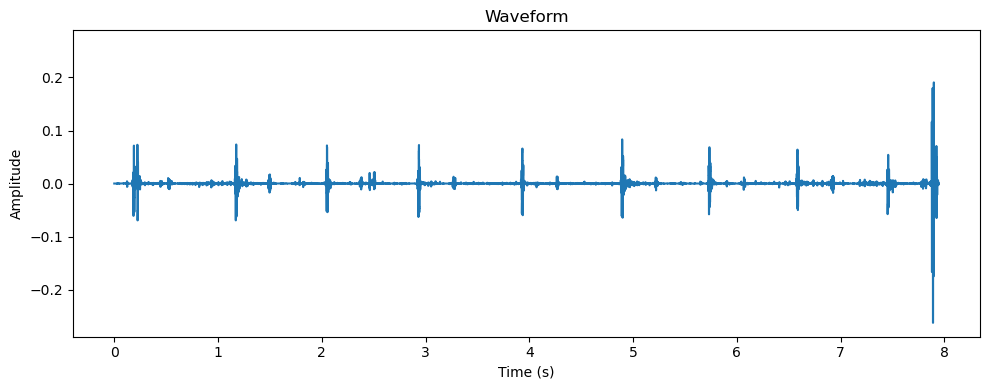

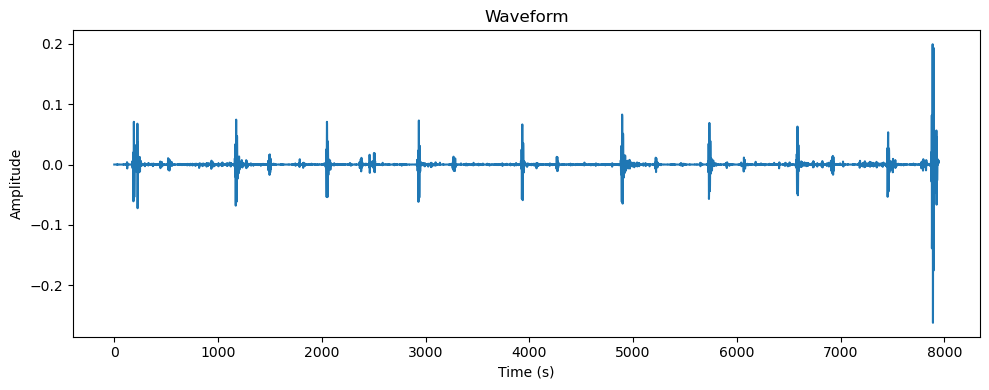

normal/201106221418.wav
NaN checking
No NaN found
normal/201103221214.wav
NaN checking
No NaN found
normal/201108011115.wav
NaN checking
No NaN found
normal/201103101140.wav
NaN checking
No NaN found
normal/201106111136.wav
NaN checking
No NaN found
normal/201102270940.wav
NaN checking
No NaN found
normal/201108011112.wav
NaN checking
No NaN found
normal/201106210943.wav
NaN checking
No NaN found
normal/201102081152.wav
NaN checking
No NaN found
normal/201108011114.wav
NaN checking
No NaN found
normal/201103140135.wav
NaN checking
No NaN found
normal/201108011118.wav
NaN checking
No NaN found
normal/201102081321.wav
NaN checking
No NaN found
normal/201105021804.wav
NaN checking
No NaN found
normal/201103170121.wav
NaN checking
No NaN found
normal/201101070538.wav
NaN checking
No NaN found
normal/201105151450.wav
NaN checking
No NaN found
normal/201106141148.wav
NaN checking
No NaN found
normal/201103090635.wav
NaN checking
No NaN found
normal/201103140822.wav
NaN checking
No NaN found


In [94]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import os
from scipy.signal import butter, filtfilt
import numpy as np


#Segmentation parameters
window_sec = 3
overlap_ratio = 0.5
overlap_sec = window_sec * overlap_ratio

#Preprocessing BPF parameters
lowcut = 25
highcut = 400
order = 4

def bandpass_filter(signal, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
    
#Signal loading
y,sr = librosa.load('normal/201103140135.wav', sr=1000)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

#The same signal after BPF
bpf_output = bandpass_filter(y, lowcut, highcut, sr, order)
plt.figure(figsize=(10, 4))
plt.plot(bpf_output)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()



#Segmentation function
def segment_signal(y, fs, window_sec, overlap_sec):
    window_len = int(window_sec * fs)
    stride_len = window_len - int(overlap_sec * fs)
    
    segments = []
    for start in range(0, len(y) - window_len + 1, stride_len):
        end = start + window_len
        segment = y[start:end]
        segments.append(segment)
    return segments



#NaNchecking
def NaN_checking(signal):
    print('NaN checking')
    if np.isnan(signal).any():
        is_nan_array = np.isnan(signal)
        nan_index = np.where(is_nan_array == True)[0]
        for index in nan_index:
            if index == 0:
                signal[index] = 0
            else:
                signal[index] = signal[index-1]
    else:
        print('No NaN found')
    return signal
    

#Amplitude thresholding,input is numpy array of preprocessed trials and labels
def artifact_trial_rejection(train_trials, train_labels, threshold):
    artefact_index = []
    for i in range(len(train_trials)):
        if np.max(np.abs(train_trials[i])) > threshold:
            artefact_index.append(i)
    train_trials = np.delete(train_trials, artefact_index)
    train_labels = np.delete(train_labels, artefact_index)
    print(f'number of removed artefactual trials: {len(artefact_index)}' )

    return train_trials, train_labels


folder_path_storage = ['normal/', 'murmur/', 'artifact/']
segments_storage = []
labels_storage = []
file_ID_storage = []
fileID = 1
for folder_path in folder_path_storage:
    file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    if folder_path == 'normal/':
        label = 1
    elif folder_path == 'murmur/':
        label = 2
    elif folder_path == 'artifact/':
        label = 3

    for file in file_list:
        #Preprocessing
        print(file)
        y,sr = librosa.load(file, sr=1000)
        NaN_checked_signal = NaN_checking(y)
        bpf_output = bandpass_filter(NaN_checked_signal, lowcut, highcut, sr, order)
        segments = segment_signal(bpf_output, sr, window_sec, overlap_sec)
        for seg in segments:
            segments_storage.append(seg)
            labels_storage.append(label) 
            file_ID_storage.append(fileID)

        fileID = fileID + 1

In [95]:
#Some sanity checking
print(len(labels_storage))
print(len(segments_storage))

Trials = np.stack(segments_storage)  
Labels = np.array(labels_storage) 
File_ID = np.array(file_ID_storage) 

#print class distribution
print(f'number of normal trials: {np.sum(Labels == 1)}' )
print(f'number of murmur trials: {np.sum(Labels == 2)}' )
print(f'number of artifact trials: {np.sum(Labels == 3)}' )

451
451
number of normal trials: 122
number of murmur trials: 129
number of artifact trials: 200


In [96]:
print(File_ID)

[  1   1   1   2   3   3   3   3   4   4   4   4   4   5   5   6   6   6
   6   6   7   7   7   7   8   8   9   9   9  10  10  10  10  11  11  11
  11  12  12  12  12  13  13  13  13  14  14  14  14  14  15  15  15  15
  16  16  16  16  17  17  17  17  18  18  19  19  19  19  20  20  20  20
  21  21  21  21  21  22  22  22  22  23  23  23  23  24  24  24  24  24
  25  25  25  25  25  26  26  26  26  26  27  27  27  27  28  28  28  28
  28  29  29  29  29  29  30  30  30  30  30  31  31  31  32  32  33  33
  33  33  33  34  34  34  34  35  35  35  35  36  36  36  36  37  37  37
  37  38  38  38  38  39  39  39  39  40  40  40  40  41  41  41  41  42
  42  42  42  43  43  43  43  45  45  45  45  46  46  46  47  47  47  47
  48  48  48  48  49  49  49  49  50  50  50  50  51  51  52  52  52  52
  53  53  53  53  54  54  54  54  54  55  55  55  55  56  56  56  56  57
  57  57  57  58  58  58  58  59  59  59  59  60  60  60  60  61  61  61
  61  62  62  62  62  63  63  63  63  64  64  64  6

In [97]:
#Features extraction
from scipy.signal import hilbert, find_peaks
from scipy.stats import entropy as scipy_entropy
from scipy.signal import savgol_filter
from scipy.signal import welch


peak_amps = [np.max(np.abs(trial)) for trial in Trials]
threshold = np.percentile(peak_amps, 99.5)
print(threshold)

#number of envelope peaks, peak-to-peak amp, entropy, RMS Energy, mean and variance of the envelope
def extract_time_domain_features(signal, sr):
    envelope = np.abs(hilbert(signal))
    #number of peaks or dominant frequency of the envelope
    smoothed_env = savgol_filter(envelope, window_length=201, polyorder=2)
    envelope_mean = np.mean(smoothed_env)
    envelope_variance = np.var(smoothed_env)
    

    N = len(smoothed_env)
    freqs = np.fft.rfftfreq(N, 1/sr)
    fft_vals = np.abs(np.fft.rfft(smoothed_env))
    #cardiac cycle rate
    envelope_dom_freq = freqs[np.argmax(fft_vals[1:]) + 1] 
    
    rms_energy = np.sqrt(np.mean(signal ** 2))

    p2p = np.max(signal) - np.min(signal)

    hist, bin_edges = np.histogram(signal, bins=50, density=True)
    signal_entropy = scipy_entropy(hist + 1e-8)  

    return np.array([envelope_mean, envelope_variance, envelope_dom_freq, p2p, rms_energy, signal_entropy])

#Bandwidth. Bandpowers. 
def extract_frequency_domain_features(signal, sr):
    freqs_psd, psd = welch(signal, fs=sr, nperseg=1024)
    freq_res = freqs_psd[1] - freqs_psd[0]

    band_25_150 = np.logical_and(freqs_psd >= 25, freqs_psd <= 150)
    band_150_400 = np.logical_and(freqs_psd > 150, freqs_psd <= 400)

    bp_25_150 = np.sum(psd[band_25_150]) * freq_res
    bp_150_400 = np.sum(psd[band_150_400]) * freq_res
    bandpower_ratio = bp_150_400/(bp_25_150 + 1e-8)

    centroid = np.sum(freqs_psd * psd) / (np.sum(psd) + 1e-8)
    bandwidth = np.sqrt(np.sum(((freqs_psd - centroid) ** 2) * psd) / (np.sum(psd) + 1e-8))

    dominant_freq = freqs_psd[np.argmax(psd[1:]) + 1]

    return np.array([bandpower_ratio, bandwidth, dominant_freq])

features = []
for trial in Trials: 
    time_features = extract_time_domain_features(trial, sr=1000)
    freq_features = extract_frequency_domain_features(trial, sr=1000)
    features_vector = np.concatenate((time_features, freq_features))
    features.append(features_vector)

features = np.stack(features)


1.0531505473203977


In [187]:
import random
#sanity checking
print('shape of features:', features.shape)


file_level_splitting = True

if file_level_splitting == False:
    #Dataset splitting
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=100)
    for train_idx, test_idx in sss.split(features, Labels):
        train_set, test_set = features[train_idx], features[test_idx]
        train_set_labels, test_set_labels = Labels[train_idx], Labels[test_idx]
        
    print('shape of train set:', train_set.shape)
    print('shape of test set:', test_set.shape)


else: 

    unique_files, file_indices = np.unique(File_ID, return_index=True)
    file_labels = Labels[file_indices]  # Label of the first segment from each file
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=100)
    for train_file_idx, test_file_idx in sss.split(unique_files, file_labels):
        train_file_ids = unique_files[train_file_idx]
        test_file_ids = unique_files[test_file_idx]
    
    train_mask = np.isin(File_ID, train_file_ids)
    test_mask = np.isin(File_ID, test_file_ids)
    
    train_set = features[train_mask]
    train_set_labels = Labels[train_mask]
    test_set = features[test_mask]
    test_set_labels = Labels[test_mask]
    
    # Sanity check
    print('shape of train set:', train_set.shape)
    print('shape of test set:', test_set.shape)

shape of features: (451, 9)
shape of train set: (363, 9)
shape of test set: (88, 9)


In [188]:
print(File_ID[test_mask])
print(File_ID[train_mask])

[  1   1   1   5   5  10  10  10  10  22  22  22  22  23  23  23  23  31
  31  31  45  45  45  45  50  50  50  50  53  53  53  53  55  55  55  55
  56  56  56  56  63  63  63  63  64  64  64  64  66  66  66  66  66  68
  68  68  68  68  76  76  76  76  76  80  80  80  80  80  82  82  82  82
  82  88  88  88  88  88 101 101 101 101 101 103 103 103 103 103]
[  2   3   3   3   3   4   4   4   4   4   6   6   6   6   6   7   7   7
   7   8   8   9   9   9  11  11  11  11  12  12  12  12  13  13  13  13
  14  14  14  14  14  15  15  15  15  16  16  16  16  17  17  17  17  18
  18  19  19  19  19  20  20  20  20  21  21  21  21  21  24  24  24  24
  24  25  25  25  25  25  26  26  26  26  26  27  27  27  27  28  28  28
  28  28  29  29  29  29  29  30  30  30  30  30  32  32  33  33  33  33
  33  34  34  34  34  35  35  35  35  36  36  36  36  37  37  37  37  38
  38  38  38  39  39  39  39  40  40  40  40  41  41  41  41  42  42  42
  42  43  43  43  43  46  46  46  47  47  47  47  48  48  

In [189]:
#Normalize features (z scoring)
#number_of_features = train_set.shape[1]

#for feature_id in range (number_of_features):
#    feature_mean = np.mean(train_set[:,feature_id])
#    feature_std = np.std(train_set[:,feature_id], ddof=0)
#    #normalize
#    train_set[:,feature_id] = (train_set[:,feature_id] - feature_mean) / feature_std
#    test_set[:,feature_id] = (test_set[:,feature_id] - feature_mean) / feature_std
#    val_set[:,feature_id] = (val_set[:,feature_id] - feature_mean) / feature_std


In [190]:
#Model building (SVM)
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

print(f'Train set shape: {train_set.shape}')

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    gamma = 'scale' if kernel == 'linear' else trial.suggest_loguniform('gamma', 1e-4, 1e1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    f1_scores = []

    for train_idx, val_idx in skf.split(train_set, train_set_labels):
        X_train, X_val = train_set[train_idx], train_set[val_idx]
        y_train, y_val = train_set_labels[train_idx], train_set_labels[val_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        clf = SVC(C=C, kernel=kernel, gamma=gamma, class_weight={1: 3, 2: 1, 3: 1})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        #f1 = f1_score(y_val, y_pred, labels=[1, 2], average='macro')
        
        true_healthy_idx = np.where(y_val == 1)[0]
        num_healthy = len(true_healthy_idx)
        num_healthy_misclassified_as_murmur = np.sum(y_pred[true_healthy_idx] == 2)
        fpr_healthy_to_murmur = num_healthy_misclassified_as_murmur / num_healthy
        
        f1_scores.append(f1)

    return np.mean(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)


[I 2025-06-24 01:33:21,714] A new study created in memory with name: no-name-d28cd6b6-ec71-4486-9370-69ce9e2405ed
/tmp/ipykernel_4150331/868402469.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2025-06-24 01:33:21,745] Trial 0 finished with value: 0.7176301040929859 and parameters: {'C': 0.03523902505626598, 'kernel': 'linear'}. Best is trial 0 with value: 0.7176301040929859.
/tmp/ipykernel_4150331/868402469.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
/tmp/ipykernel_4150331/868402469.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

Train set shape: (363, 9)


/tmp/ipykernel_4150331/868402469.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2025-06-24 01:33:22,056] Trial 7 finished with value: 0.8240420786136848 and parameters: {'C': 192.90843720035363, 'kernel': 'linear'}. Best is trial 4 with value: 0.859357711879575.
/tmp/ipykernel_4150331/868402469.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
[I 2025-06-24 01:33:22,066] Trial 8 finished with value: 0.7434976806769243 and parameters: {'C': 0.06952988145363401, 'kernel': 'linear'}. Best is trial 4 with value: 0.859357711879575.
/tmp/ipykernel_4150331/868402469.py:11: Fut

In [191]:
#secondary classifier

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    gamma = 'scale' if kernel == 'linear' else trial.suggest_loguniform('gamma', 1e-4, 1e1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    f1_scores = []
    
    binary_mask = np.isin(train_set_labels, [1, 2])
    binary_train_set = train_set[binary_mask]
    binary_train_labels = train_set_labels[binary_mask]
    
    for train_idx, val_idx in skf.split(binary_train_set, binary_train_labels):
        X_train, X_val = binary_train_set[train_idx], binary_train_set[val_idx]
        y_train, y_val = binary_train_labels[train_idx], binary_train_labels[val_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        clf = SVC(C=C, kernel=kernel, gamma=gamma, class_weight={1: 1, 2: 1})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        #f1 = f1_score(y_val, y_pred, average='macro')
        f1 = f1_score(y_val, y_pred, labels=[1, 2], average='macro')
        
        true_healthy_idx = np.where(y_val == 1)[0]
        num_healthy = len(true_healthy_idx)
        num_healthy_misclassified_as_murmur = np.sum(y_pred[true_healthy_idx] == 2)
        fpr_healthy_to_murmur = num_healthy_misclassified_as_murmur / num_healthy
        
        f1_scores.append(fpr_healthy_to_murmur)

    return np.mean(f1_scores)

study_secondary_classifier = optuna.create_study(direction='minimize')
study_secondary_classifier.optimize(objective, n_trials=70)

[I 2025-06-24 01:33:25,079] A new study created in memory with name: no-name-71584331-f428-4d51-91a8-84ef5088a57a
/tmp/ipykernel_4150331/2906018808.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e3)
/tmp/ipykernel_4150331/2906018808.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = 'scale' if kernel == 'linear' else trial.suggest_loguniform('gamma', 1e-4, 1e1)
[I 2025-06-24 01:33:25,115] Trial 0 finished with value: 0.1657142857142857 and parameters: {'C': 241.5287866571879, 'kernel': 'poly', 'gamma': 0.11884067531713197}. Best is trial 0 with value: 0.1657142857142857.
/tmp/ipykernel_4150331/2906018808.py:4: Futur

Test macro F1: 0.7154623154623154
Overall test accuracy: 0.7727272727272727
test accuracy healthy: 0.4
healthy sample size: 20
test accuracy murmur: 0.8571428571428571
murmur sample size: 28
test accuracy artifact: 0.9
artifact sample size: 40


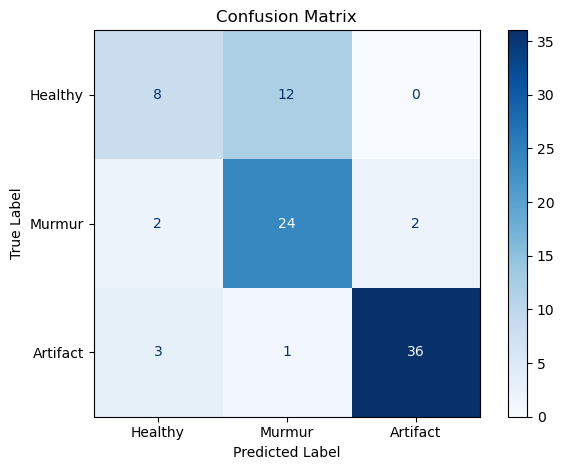

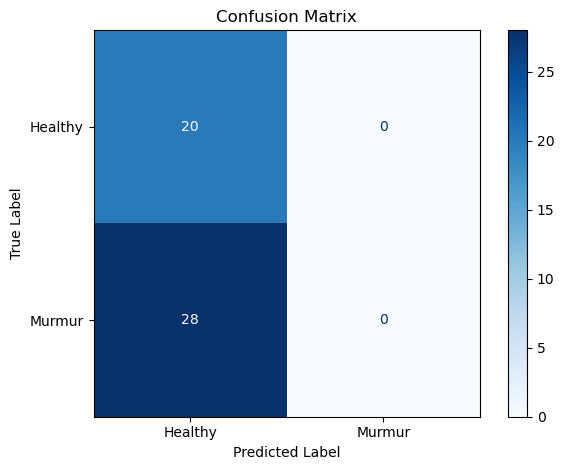

In [192]:
#Fit scaler on the full training set
#Retrain using best hyperparameters
#Evaluate: Test set performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
normalized_train_set = scaler.fit_transform(train_set)
normalized_test_set = scaler.transform(test_set)

clf = SVC(**study.best_params)
clf.fit(normalized_train_set, train_set_labels)

test_set_predict = clf.predict(normalized_test_set)
test_f1 = f1_score(test_set_labels, test_set_predict, average='macro')
print("Test macro F1:", test_f1)

accuracy = accuracy_score(test_set_labels, test_set_predict)
print("Overall test accuracy:", accuracy)

healthy_index = np.where(test_set_labels == 1)[0]
accuracy = accuracy_score(test_set_labels[healthy_index], test_set_predict[healthy_index])
print("test accuracy healthy:", accuracy)
print("healthy sample size:", len(healthy_index))
murmur_index = np.where(test_set_labels == 2)[0]
accuracy = accuracy_score(test_set_labels[murmur_index], test_set_predict[murmur_index])
print("test accuracy murmur:", accuracy)
print("murmur sample size:", len(murmur_index))
artifact_index = np.where(test_set_labels == 3)[0]
accuracy = accuracy_score(test_set_labels[artifact_index], test_set_predict[artifact_index])
print("test accuracy artifact:", accuracy)
print("artifact sample size:", len(artifact_index))

#Confusion matrix 
cm = confusion_matrix(test_set_labels, test_set_predict, labels=[1, 2, 3])
class_names = ['Healthy', 'Murmur', 'Artifact']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')  
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#testing performance of secondary binary classifier
clf = SVC(**study_secondary_classifier.best_params)
binary_mask = np.isin(train_set_labels, [1, 2])
binary_train_set = normalized_train_set[binary_mask]
binary_train_labels = train_set_labels[binary_mask]
clf.fit(binary_train_set, binary_train_labels)
binary_mask = np.isin(test_set_labels, [1, 2])
binary_test_set = normalized_test_set[binary_mask]
binary_test_labels = test_set_labels[binary_mask]
test_set_predict = clf.predict(binary_test_set)

cm = confusion_matrix(binary_test_labels, test_set_predict, labels=[1, 2])
class_names = ['Healthy', 'Murmur']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')  
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [103]:
print(study.best_params)


{'C': 0.003303729909564081, 'kernel': 'linear'}


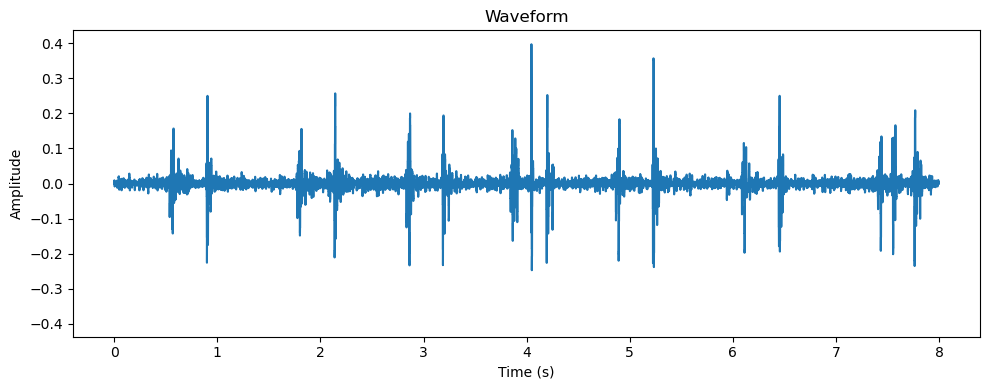

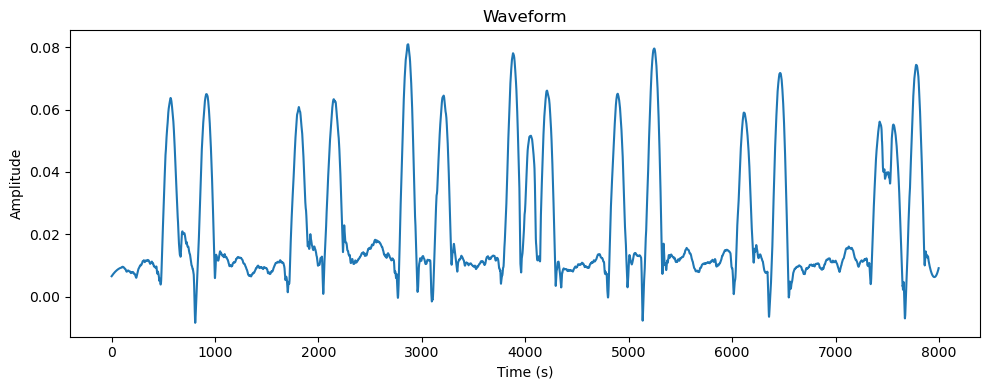

0.8752188047011753
1.664704209829154
0.08736366884815165
91.26932383833581


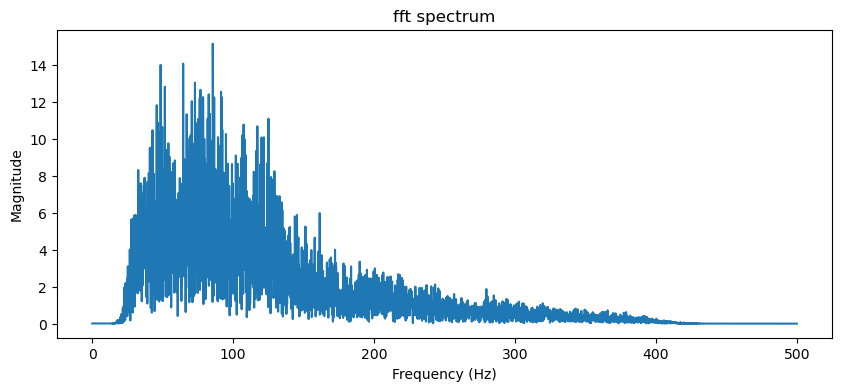

In [4]:
#Example envelope waveform

from scipy.signal import hilbert, find_peaks
from scipy.signal import savgol_filter
from scipy.stats import entropy as scipy_entropy
from scipy.signal import welch

y,sr = librosa.load('murmur/201108222231.wav', sr=1000)
y,sr = librosa.load('normal/201105021654.wav', sr=1000)

bpf_output = bandpass_filter(y, lowcut, highcut, sr, order)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(bpf_output, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

envelope = np.abs(hilbert(bpf_output))
smoothed_env = savgol_filter(envelope, window_length=201, polyorder=2)


plt.figure(figsize=(10, 4))
plt.plot(smoothed_env)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

N = len(smoothed_env)
freqs = np.fft.rfftfreq(N, 1/sr)
fft_vals = np.abs(np.fft.rfft(smoothed_env))
dom_freq = freqs[np.argmax(fft_vals[1:]) + 1]  # skip DC
print(dom_freq)

hist, bin_edges = np.histogram(bpf_output, bins=50, density=True)
signal_entropy = scipy_entropy(hist + 1e-8)  # Avoid log(0)
print(signal_entropy)


#plotting fft spectrum
N = len(bpf_output)
freqs = np.fft.rfftfreq(N, 1/sr)
fft_vals = np.abs(np.fft.rfft(bpf_output))
plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_vals)
plt.title('fft spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

freqs_psd, psd = welch(bpf_output, fs=sr, nperseg=1024)
freq_res = freqs_psd[1] - freqs_psd[0]

band_25_150 = np.logical_and(freqs_psd >= 25, freqs_psd <= 150)
band_150_400 = np.logical_and(freqs_psd > 150, freqs_psd <= 400)

bp_25_150 = np.sum(psd[band_25_150]) * freq_res
bp_150_400 = np.sum(psd[band_150_400]) * freq_res
print(bp_150_400/bp_25_150)
print(np.sum(freqs_psd * psd) / (np.sum(psd) + 1e-8))

0.1593233530012803
67.39073711423882


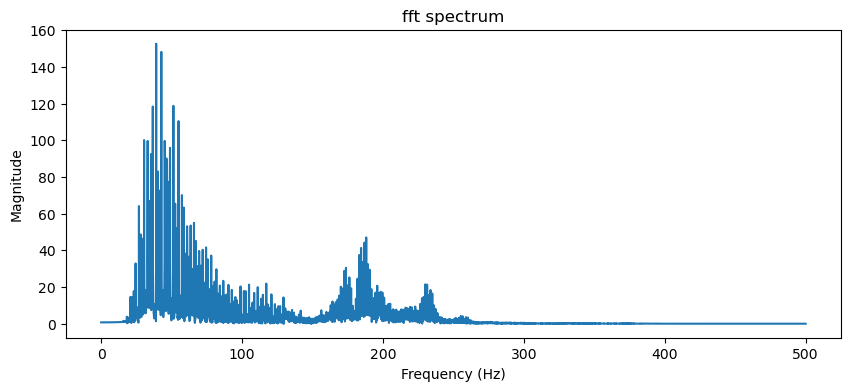

In [5]:
y,sr = librosa.load('murmur/201108222231.wav', sr=1000)
bpf_output = bandpass_filter(y, lowcut, highcut, sr, order)
N = len(bpf_output)
freqs = np.fft.rfftfreq(N, 1/sr)
fft_vals = np.abs(np.fft.rfft(bpf_output))
plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_vals)
plt.title('fft spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

freqs_psd, psd = welch(bpf_output, fs=sr, nperseg=1024)
freq_res = freqs_psd[1] - freqs_psd[0]

band_25_150 = np.logical_and(freqs_psd >= 25, freqs_psd <= 150)
band_150_400 = np.logical_and(freqs_psd > 150, freqs_psd <= 400)

bp_25_150 = np.sum(psd[band_25_150]) * freq_res
bp_150_400 = np.sum(psd[band_150_400]) * freq_res
print(bp_150_400/bp_25_150)
print(np.sum(freqs_psd * psd) / (np.sum(psd) + 1e-8))